In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from keras.optimizers import Adam, RMSprop
from keras.models import Model, Sequential
from keras.metrics import mean_absolute_error, mae, mse
from keras.layers import Dense, Dropout, Input
from keras.regularizers import l2, l1_l2

from datetime import datetime

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **Define some useful functions**

In [0]:
def load_data(url, columns=[1, 2, 4, 6, 11]):
  """ Load the dataset, change the column names, 
      and replace the categorical data by numeric values
  """
  # load data
  df = pd.read_csv(url, header=None, usecols=columns)
  print('Original Data shape: ', np.shape(df))

  # re-name all columns
  column_names = ['Price', 'PurchaseDate', 'PropertyType', 'LeaseDuration', 'City']
  df.columns = column_names
  
  # resplace column values
  df['PropertyType'] = df['PropertyType'].replace({'F':0, 'D':1, 'S':2, 'T':3, 'O':4})
  df['LeaseDuration'] = df['LeaseDuration'].replace({'L':0, 'F':1, 'U':2})
  df.loc[df['City']=='LONDON', 'City'] = 0
  df.loc[df['City'] != 0, 'City'] = 1

  # convert column values to appropriate dtype (to save memory)
  df['PurchaseDate'] = pd.to_datetime(df['PurchaseDate'])
  df['Price'] = pd.to_numeric(df["Price"], downcast="integer")
  df['PropertyType'] = pd.to_numeric(df['PropertyType'], downcast='integer')
  df['LeaseDuration'] = pd.to_numeric(df["LeaseDuration"], downcast="integer")
  df['City'] = pd.to_numeric(df["City"], downcast="integer")
  
  return df

In [0]:
def split_train_test(df):
  """ Split the data into training and test dataset 
  """
  # purchases prior to 1/1/2016 as training 
  cutoff = datetime(2016, 1, 1)
  column_sels = ['Price', 'PropertyType', 'LeaseDuration', 'City']
  train_df = df.loc[df['PurchaseDate'] <= cutoff][column_sels]
  test_df = df.loc[df['PurchaseDate'] > cutoff][column_sels] 
  
  # remove duplicates
  train_df.drop_duplicates(keep='first', inplace=True)
  test_df.drop_duplicates(keep='first', inplace=True)
  
  print("Train (and val) shape: ", train_df.shape)
  print("Test shape: ", test_df.shape)  

  return train_df, test_df  

In [0]:
def prep(train_df, test_df):
  """ Prepare inputs/targets pair for training, and testing
      using one-hot encoding (for categorical data), and 
      down-scale the target values (prices) 
  """
  # training 
  train_X = train_df[['PropertyType', 'LeaseDuration', 'City']]
  train_y = train_df['Price'] 

  # testing 
  test_X = test_df[['PropertyType', 'LeaseDuration', 'City']]
  test_y = test_df['Price']

  # one-hot encoding the inputs
  ohc = OneHotEncoder(handle_unknown='ignore')
  ohc.fit(train_X)
  train_X = ohc.transform(train_X)
  test_X = ohc.transform(test_X)

  # convert the targets to smaller range
  train_y = np.log1p(train_y * 1e-3)
  test_y = np.log1p(test_y * 1e-3)
  
  return (train_X, train_y), (test_X, test_y)  

# **Loading and pre-processing the dataset**

In [0]:
# load the data
url = '/content/drive/My Drive/pp-complete.csv'
df = load_data(url)
train_df, test_df = split_train_test(df)
(train_X, train_y), (test_X, test_y)  = prep(train_df, test_df)

Data shape:  (24852949, 5)


### **Linear Regression**

In [0]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn import preprocessing

# store score from all models
scores_map = {}

l_regression = linear_model.LinearRegression()
kf = KFold(n_splits=10)
min_max_scaler = preprocessing.MinMaxScaler()
scores = cross_val_score(l_regression, train_X , train_y, cv=kf, scoring='neg_mean_squared_error')
scores_map['LinearRegression'] = scores
print("MSE: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std()))

l_ridge = linear_model.Ridge()
scores = cross_val_score(l_ridge, train_X, train_y, cv=kf, scoring='neg_mean_squared_error')
scores_map['Ridge'] = scores
print("MSE: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std()))

MSE: -1.08883 (+/- 0.01375)
MSE: -1.08883 (+/- 0.01375)


### **Polinomial regression with L2**

In [0]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

model = make_pipeline(PolynomialFeatures(degree=3), linear_model.Ridge())
scores = cross_val_score(model, train_X, train_y, cv=kf, scoring='neg_mean_squared_error')
scores_map['PolyRidge'] = scores
print("MSE: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std()))

MSE: -1.07669 (+/- 0.01399)


### **Decision Tree Regressor**

In [0]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# use gridSearch to find the "best" model
desc_tr = DecisionTreeRegressor(max_depth=5)
grid_sv = GridSearchCV(desc_tr, cv=kf, param_grid={"max_depth" : [1, 2, 3, 4, 5, 6, 7]}, scoring='neg_mean_squared_error')
grid_sv.fit(x_scaled, y)
print("Best classifier :", grid_sv.best_estimator_)

In [0]:
# run the best model found by grid search
scores = cross_val_score(desc_tr, train_X, train_y, cv=kf, scoring='neg_mean_squared_error')
scores_map['DecisionTreeRegressor'] = scores
print("MSE: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std()))

MSE: -1.07826 (+/- 0.01391)


### **k-Nearest Neighbours**

In [0]:
from sklearn.neighbors import KNeighborsRegressor

# use GS to look for the best model
knn = KNeighborsRegressor(n_neighbors=7)
scores = cross_val_score(knn, train_X, train_y, cv=kf, scoring='neg_mean_squared_error')
scores_map['KNeighborsRegressor'] = scores
grid_sv = GridSearchCV(knn, cv=kf, 
                       param_grid={"n_neighbors" : [2, 3, 4, 5, 6, 7]}, 
                       scoring='neg_mean_squared_error')
grid_sv.fit(x_scaled, y)
print("Best classifier :", grid_sv.best_estimator_)


In [0]:
# run the best model found
knn = KNeighborsRegressor(n_neighbors=7)
scores = cross_val_score(knn, train_X, train_y, cv=kf, scoring='neg_mean_squared_error')
scores_map['KNeighborsRegressor'] = scores
print("KNN Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std()))

### **Gradient Boosting Regressor**

In [0]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(alpha=0.9, learning_rate=0.05, max_depth=2, 
                                min_samples_leaf=5, min_samples_split=2, 
                                n_estimators=100, random_state=30)

# use gridSearch to find the best model
param_grid={'n_estimators':[100, 200], 'learning_rate': [0.1,0.05,0.02], 
            'max_depth':[2, 4,6], 'min_samples_leaf':[3,5,9]}
grid_sv = GridSearchCV(gbr, cv=kf, param_grid=param_grid, 
                       scoring='neg_mean_squared_error')
grid_sv.fit(train_X, train_y)
print("Best classifier :", grid_sv.best_estimator_)

Best classifier : GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=9, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=30, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [0]:
# run the best model found by gridSearch
gbr = GradientBoostingRegressor(alpha=0.9, learning_rate=0.05, max_depth=4, 
                                min_samples_leaf=9, min_samples_split=2, 
                                n_estimators=200, random_state=30)
scores = cross_val_score(gbr, train_X , train_y, cv=kf, scoring='neg_mean_squared_error')
scores_map['GradientBoostingRegressor'] = scores
print("MSE: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std()))

MSE: -1.07668 (+/- 0.01400)


### **Support Vector Regressor**

In [0]:
from sklearn.svm import SVR

# grid search
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
grid_sv = GridSearchCV(svr_rbf, cv=kf, param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 5)}, scoring='neg_mean_squared_error')
grid_sv.fit(x_scaled, y)
print("Best classifier :", grid_sv.best_estimator_)

In [0]:
# best model found by GS
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
scores = cross_val_score(svr_rbf, train_X , train_y, cv=kf, scoring='neg_mean_squared_error')
scores_map['SVR'] = scores
print("MSE: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std()))

### **Comparison between models considered so far**

['LinearRegression', 'Ridge', 'PolyRidge', 'DecisionTreeRegressor', 'GradientBoostingRegressor']


0   -1.093313
1   -1.094378
2   -1.058330
3   -1.071742
4   -1.067663
5   -1.073686
6   -1.105118
7   -1.067244
8   -1.078656
9   -1.072502
Name: DecisionTreeRegressor, dtype: float64

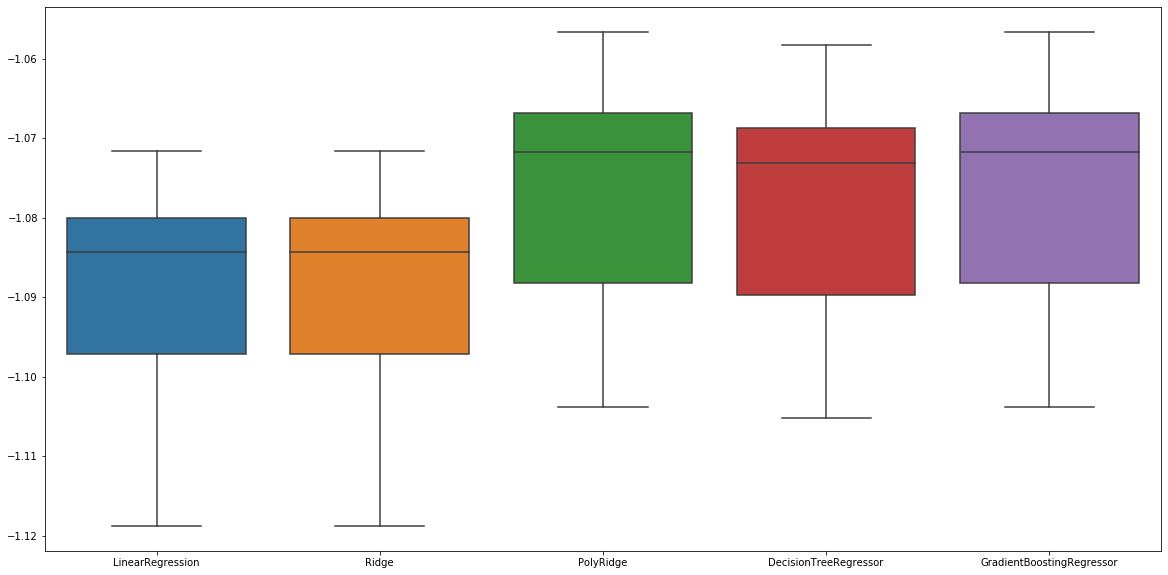

In [0]:
plt.figure(figsize=(20, 10))
scores_map = pd.DataFrame(scores_map)
sns.boxplot(data=scores_map)